# Imports


In [185]:
# import find_context from baselines/bm25/bm25.py
import random
from urllib import parse
from tqdm import tqdm
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt

# Helpful Functions


In [186]:
def compute_mrr(rankings, k_values=[1, 5, 10]):
    mrr_at_k = {str(k): {'score': 0, 'cl': [None, None]} for k in k_values}
    mrr_at_k_lists = {str(k): [0 for _ in range(100)] for k in k_values}
    # compute MRR for each k
    # and compute confidence intervals for each k
    mrr_at_max = {'score': 0, 'cl': [None, None]}
    mrr_at_max_list = [0 for _ in range(100)]
    
    # extract 100 samples
    for i in range(100):
        sample = random.choices(rankings, k = len(rankings))
        for rank in sample:
            for k in mrr_at_k_lists.keys():
                if rank <= int(k):
                    mrr_at_k_lists[str(k)][i] += (1 / rank) / len(sample)
            mrr_at_max_list[i] += (1 / rank) / len(sample)
    
    # sort values for confidence intervals
    for k in mrr_at_k_lists.keys():
        mrr_at_k_lists[str(k)].sort()
    mrr_at_max_list.sort()
        
    # find mean score and 90% confidence interval
    for k in mrr_at_k_lists.keys():
        mrr_at_k[str(k)]['score'] = np.mean(mrr_at_k_lists[str(k)]) * 1000 // 1 / 1000
        mrr_at_k[str(k)]['cl'] = [mrr_at_k_lists[str(k)][4] * 1000 // 1 / 1000, mrr_at_k_lists[str(k)][94] * 1000 // 1 / 1000]
    mrr_at_max['score'] = np.mean(mrr_at_max_list) * 1000 // 1 / 1000
    mrr_at_max['cl'] = [mrr_at_max_list[4] * 1000 // 1 / 1000, mrr_at_max_list[94] * 1000 // 1 / 1000]
    
    # add max to mrr_at_k
    mrr_at_k['max'] = mrr_at_max

    return mrr_at_k

In [187]:
def compute_stratified_mrr(rankings, categories, categories_values, k_values=[1, 5, 10]):
    ranks_stratified = {category: [] for category in categories_values}
    for rank, category in zip(rankings, categories):
        ranks_stratified[category].append(rank)
        
    discrete_mrr_at_k = {}
        
    for category in categories_values:
        discrete_mrr_at_k[category] = compute_mrr(ranks_stratified[category], k_values)
        
    return discrete_mrr_at_k

In [188]:
def compute_hits(rankings, k_values=[1, 5, 10]):
    hits_at_k = {str(k): {'score': 0, 'cl': [None, None]} for k in k_values}
    hits_at_k_lists = {str(k): [0 for _ in range(100)] for k in k_values}
    
    # extract 100 samples
    for i in range(100):
        sample = random.choices(rankings, k = len(rankings))
        for rank in sample:
            for k in hits_at_k_lists.keys():
                if rank <= int(k):
                    hits_at_k_lists[str(k)][i] += 1 / len(sample)
    
    # sort values for confidence intervals
    for k in hits_at_k_lists.keys():
        hits_at_k_lists[str(k)].sort()
    
    # find mean score and 90% confidence interval
    for k in hits_at_k_lists.keys():
        hits_at_k[str(k)]['score'] = np.mean(hits_at_k_lists[str(k)]) * 1000 // 1 / 1000
        hits_at_k[str(k)]['cl'] = [hits_at_k_lists[str(k)][4] * 1000 // 1 / 1000, hits_at_k_lists[str(k)][94] * 1000 // 1 / 1000]
    
    return hits_at_k

In [189]:
def compute_stratified_hits(rankings, categories, categories_values, k_values=[1, 5, 10]):
    ranks_stratified = {category: [] for category in categories_values}
    for rank, category in zip(rankings, categories):
        ranks_stratified[category].append(rank)
    
    discrete_hits_at_k = {}
        
    for category in categories_values:
        discrete_hits_at_k[category] = compute_hits(ranks_stratified[category], k_values)
        
    return discrete_hits_at_k

In [190]:
def compute_ndcg(rankings, k_values=[1, 5, 10]):
    ndcg_at_k = {str(k): {'score': 0, 'cl': [None, None]} for k in k_values}
    ndcg_at_k_lists = {str(k): [0 for _ in range(100)] for k in k_values}
    # compute NDCG for each k
    # and compute confidence intervals for each k
    ndcg_at_max = {'score': 0, 'cl': [None, None]}
    ndcg_at_max_list = [0 for _ in range(100)]
    
    # extract 100 samples
    for i in range(100):
        sample = random.choices(rankings, k = len(rankings))
        for rank in sample:
            for k in ndcg_at_k_lists.keys():
                if rank <= int(k):
                    ndcg_at_k_lists[str(k)][i] += (1 / np.log2(rank + 1)) / len(sample)
            ndcg_at_max_list[i] += (1 / np.log2(rank + 1)) / len(sample)
    
    # sort values for confidence intervals
    for k in ndcg_at_k_lists.keys():
        ndcg_at_k_lists[str(k)].sort()
    ndcg_at_max_list.sort()
        
    # find mean score and 90% confidence interval
    for k in ndcg_at_k_lists.keys():
        ndcg_at_k[str(k)]['score'] = np.mean(ndcg_at_k_lists[str(k)]) * 1000 // 1 / 1000
        ndcg_at_k[str(k)]['cl'] = [ndcg_at_k_lists[str(k)][4] * 1000 // 1 / 1000, ndcg_at_k_lists[str(k)][94] * 1000 // 1 / 1000]
    ndcg_at_max['score'] = np.mean(ndcg_at_max_list) * 1000 // 1 / 1000
    ndcg_at_max['cl'] = [ndcg_at_max_list[4] * 1000 // 1 / 1000, ndcg_at_max_list[94] * 1000 // 1 / 1000]
    
    # add max to ndcg_at_k
    ndcg_at_k['max'] = ndcg_at_max
    
    return ndcg_at_k

In [191]:
def compute_stratified_ndcg(rankings, categories, categories_values, k_values=[1, 5, 10]):
    ranks_stratified = {category: [] for category in categories_values}
    for rank, category in zip(rankings, categories):
        ranks_stratified[category].append(rank)
    
    discrete_ndcg_at_k = {}
        
    for category in categories_values:
        discrete_ndcg_at_k[category] = compute_ndcg(ranks_stratified[category], k_values)
        
    return discrete_ndcg_at_k

# Load data


In [192]:
test_df = pd.read_parquet('test_ranking_scores.parquet')
test_df

,source_title,source_lead,target_title,target_lead,link_context,source_section,context_span_start_index,context_span_end_index,context_sentence_start_index,context_sentence_end_index,...,model_indep_rank,model_indep_corrupt_rank,model_indep_corrupt_section_rank,model_indep_corrupt_section_random_rank,model_indep_corrupt_section_mentions_rank,model_ranking_rank,model_ranking_corrupt_rank,model_ranking_corrupt_section_rank,model_ranking_corrupt_section_random_rank,model_ranking_corrupt_section_mentions_rank
0,MBC 3,MBC 3 is a free-to-air children's channel laun...,PAW Patrol,PAW Patrol is a Canadian CGI-animated televisi...,PAW Patrol\nThe Penguins of Madagascar\nRise o...,Programming,105,118,105,119,...,1,1,1,1,1,1,1,1,1,1
1,Hezbollah,Hezbollah is an Islamic political party and pa...,Ayatollah Khomeini,Ayatollah Khomeini was born Sayyed Ruhollah Mu...,History,History,8,557,270,370,...,20,1,1,1,1,20,1,1,1,1
2,"Austell, Georgia",Austell is a city in Cobb County in the U.S. s...,2020 United States Census,"The 2020 United States Census, known as Census...",Austell is a city in Cobb County in the U.S. s...,Lead,0,166,108,166,...,1,1,1,1,1,1,1,1,1,1
3,Organism,An organism is an individual living thing. It ...,Tree of life (biology),The tree of life is a metaphor which expresses...,Origin\nThe project works on the relationships...,Origin,7,358,7,81,...,9,19,19,15,7,14,20,19,18,15
4,Radim Uzel,Radim Uzel was a Czech sexologist and academic...,Academia,Academia is a word for higher education and re...,Radim Uzel (27 March 1940 – 2 May 2022) was a ...,Lead,0,434,0,76,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Elle Fanning,"Mary Elle Fanning, known as Elle Fanning, is a...",Jill Arrington,"Tiffany ""Jill"" Arrington is an American sports...","Personal life\nFanning was born on April 9, 19...",Personal life,14,714,319,433,...,2,3,3,2,1,1,1,1,2,1
996,Ruth Davidson,Ruth Davidson is a Scottish politician. She wa...,Sunday school,Sunday School is a kind of schooling found in ...,"She was studied at Knowepark Primary School, a...",Early Life,0,615,469,512,...,4,3,4,3,4,1,3,1,1,1
997,Eiffel Tower,The Eiffel Tower is a landmark in Paris. It wa...,French Revolution,The French Revolution was a time when France w...,"The Eiffel Tower (French: La Tour Eiffel, , IP...",Lead,0,592,205,341,...,1,1,1,1,1,1,1,1,1,1
998,2022 Copa America Feminina,The 2022 Copa América Femenina will be the 9th...,"Armenia, Colombia","Armenia is a Colombian municipality, capital o...",(2022-07-21)\n2022-07-21\nEstadio Olímpico Pas...,Group stage,88,115,88,115,...,4,1,1,1,7,11,1,1,8,13


## Compute Metrics

In [193]:
mrr_at_k = {}
for column in test_df.columns:
    if 'rank' in column:
        mrr_at_k[column] = compute_mrr(test_df[column].tolist())

In [194]:
stratified_mrr_at_k = {}
for column in test_df.columns:
    if 'rank' in column:
        stratified_mrr_at_k[column] = compute_stratified_mrr(test_df[column].tolist(), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique())

In [195]:
hits_at_k = {}
for column in test_df.columns:
    if 'rank' in column:
        hits_at_k[column] = compute_hits(test_df[column].tolist())

In [196]:
stratified_hits_at_k = {}
for column in test_df.columns:
    if 'rank' in column:
        stratified_hits_at_k[column] = compute_stratified_hits(test_df[column].tolist(), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique())

In [197]:
ndcg_at_k = {}
for column in test_df.columns:
    if 'rank' in column:
        ndcg_at_k[column] = compute_ndcg(test_df[column].tolist())

In [198]:
stratified_ndcg_at_k = {}
for column in test_df.columns:
    if 'rank' in column:
        stratified_ndcg_at_k[column] = compute_stratified_ndcg(test_df[column].tolist(), test_df['noise_strategy'].tolist(), test_df['noise_strategy'].unique())

In [199]:
std = {}
for column in test_df.columns:
    if 'rank' in column:
        std[column] = test_df[column].std()

In [200]:
stratified_std = {}
for column in test_df.columns:
    if 'rank' in column:
        stratified_std[column] = test_df.groupby('noise_strategy')[column].std()

# Print standard deviation results


In [201]:
for column in std:
    print(f"{column} std: {std[column]}")
    for category in stratified_std[column].keys():
        print(f"\t{column} std for {category}: {stratified_std[column][category]}")

random_rank std: 5.778272010508629
	random_rank std for mask_mention: 5.919979008029173
	random_rank std for mask_sentence: 5.807931298170574
	random_rank std for mask_span: 5.5120124776163255
	random_rank std for no_mask: 5.705113966492279
bm25_rank std: 6.849117783657571
	bm25_rank std for mask_mention: 6.384499643570081
	bm25_rank std for mask_sentence: 6.530705514820044
	bm25_rank std for mask_span: 7.1226322009320056
	bm25_rank std for no_mask: 5.88011429380781
bm25_mentions_rank std: 6.857125576447552
	bm25_mentions_rank std for mask_mention: 6.3819435406833165
	bm25_mentions_rank std for mask_sentence: 6.558785759326068
	bm25_mentions_rank std for mask_span: 7.17694841132913
	bm25_mentions_rank std for no_mask: 5.654917084390991
exact_match_rank std: 6.123417938312496
	exact_match_rank std for mask_mention: 6.456602331268812
	exact_match_rank std for mask_sentence: 6.448992932918433
	exact_match_rank std for mask_span: 5.775607006691426
	exact_match_rank std for no_mask: 2.92320

# Plot results

In [202]:
# set matplotlib params
plt.rcParams.update({'font.size': 15})
# set marker size
markersize = 10

## Plot aggregated results

In [203]:
columns = ['random_rank', 'bm25_mentions_rank', 'fuzzy_match_rank', 'model_ranking_corrupt_section_mentions_rank']
labels = ['Random', 'BM25', 'String Match', 'Ours']
markers = ['o', 'v', 's', 'D']

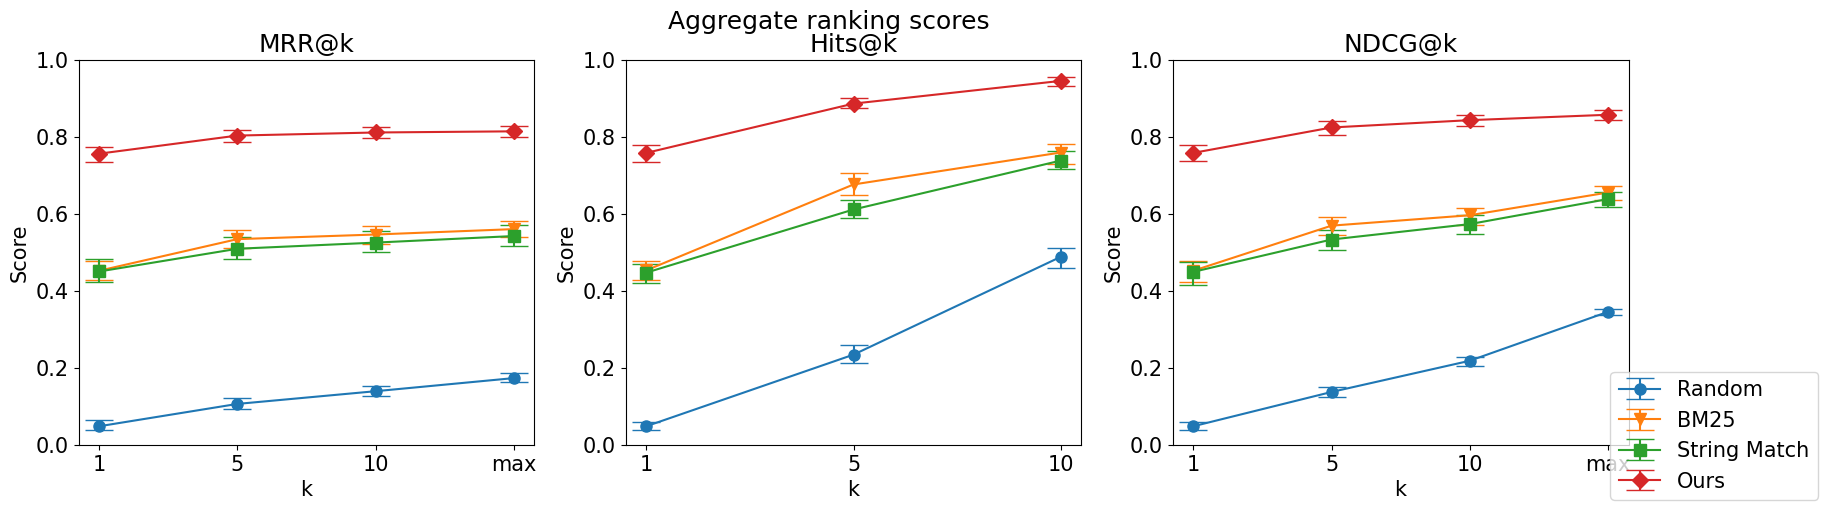

In [204]:
# Plot ranking scores
# create a grid of 1x3 plots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Aggregate ranking scores')    
for ax in axs:
    ax.set_ylim(0, 1)
    ax.set_xlabel('k')
    ax.set_ylabel('Score')

axs[0].set_title('MRR@k')
for column, label, marker in zip(columns, labels, markers):
    axs[0].errorbar(mrr_at_k[column].keys(), [mrr_at_k[column][k]['score'] for k in mrr_at_k[column].keys()], yerr=[[mrr_at_k[column][k]['score'] - mrr_at_k[column][k]['cl'][0] for k in mrr_at_k[column].keys()], [mrr_at_k[column][k]['cl'][1] - mrr_at_k[column][k]['score'] for k in mrr_at_k[column].keys()]], label=label, marker=marker, capsize=10, markersize=8)

axs[1].set_title('Hits@k')
for column, label, marker in zip(columns, labels, markers):
    axs[1].errorbar(hits_at_k[column].keys(), [hits_at_k[column][k]['score'] for k in hits_at_k[column].keys()], yerr=[[hits_at_k[column][k]['score'] - hits_at_k[column][k]['cl'][0] for k in hits_at_k[column].keys()], [hits_at_k[column][k]['cl'][1] - hits_at_k[column][k]['score'] for k in hits_at_k[column].keys()]], label=label, marker=marker, capsize=10, markersize=8)

axs[2].set_title('NDCG@k')
for column, label, marker in zip(columns, labels, markers):
    axs[2].errorbar(ndcg_at_k[column].keys(), [ndcg_at_k[column][k]['score'] for k in ndcg_at_k[column].keys()], yerr=[[ndcg_at_k[column][k]['score'] - ndcg_at_k[column][k]['cl'][0] for k in ndcg_at_k[column].keys()], [ndcg_at_k[column][k]['cl'][1] - ndcg_at_k[column][k]['score'] for k in ndcg_at_k[column].keys()]], label=label, marker=marker, capsize=10, markersize=8)

handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

## Plot Stratified Results

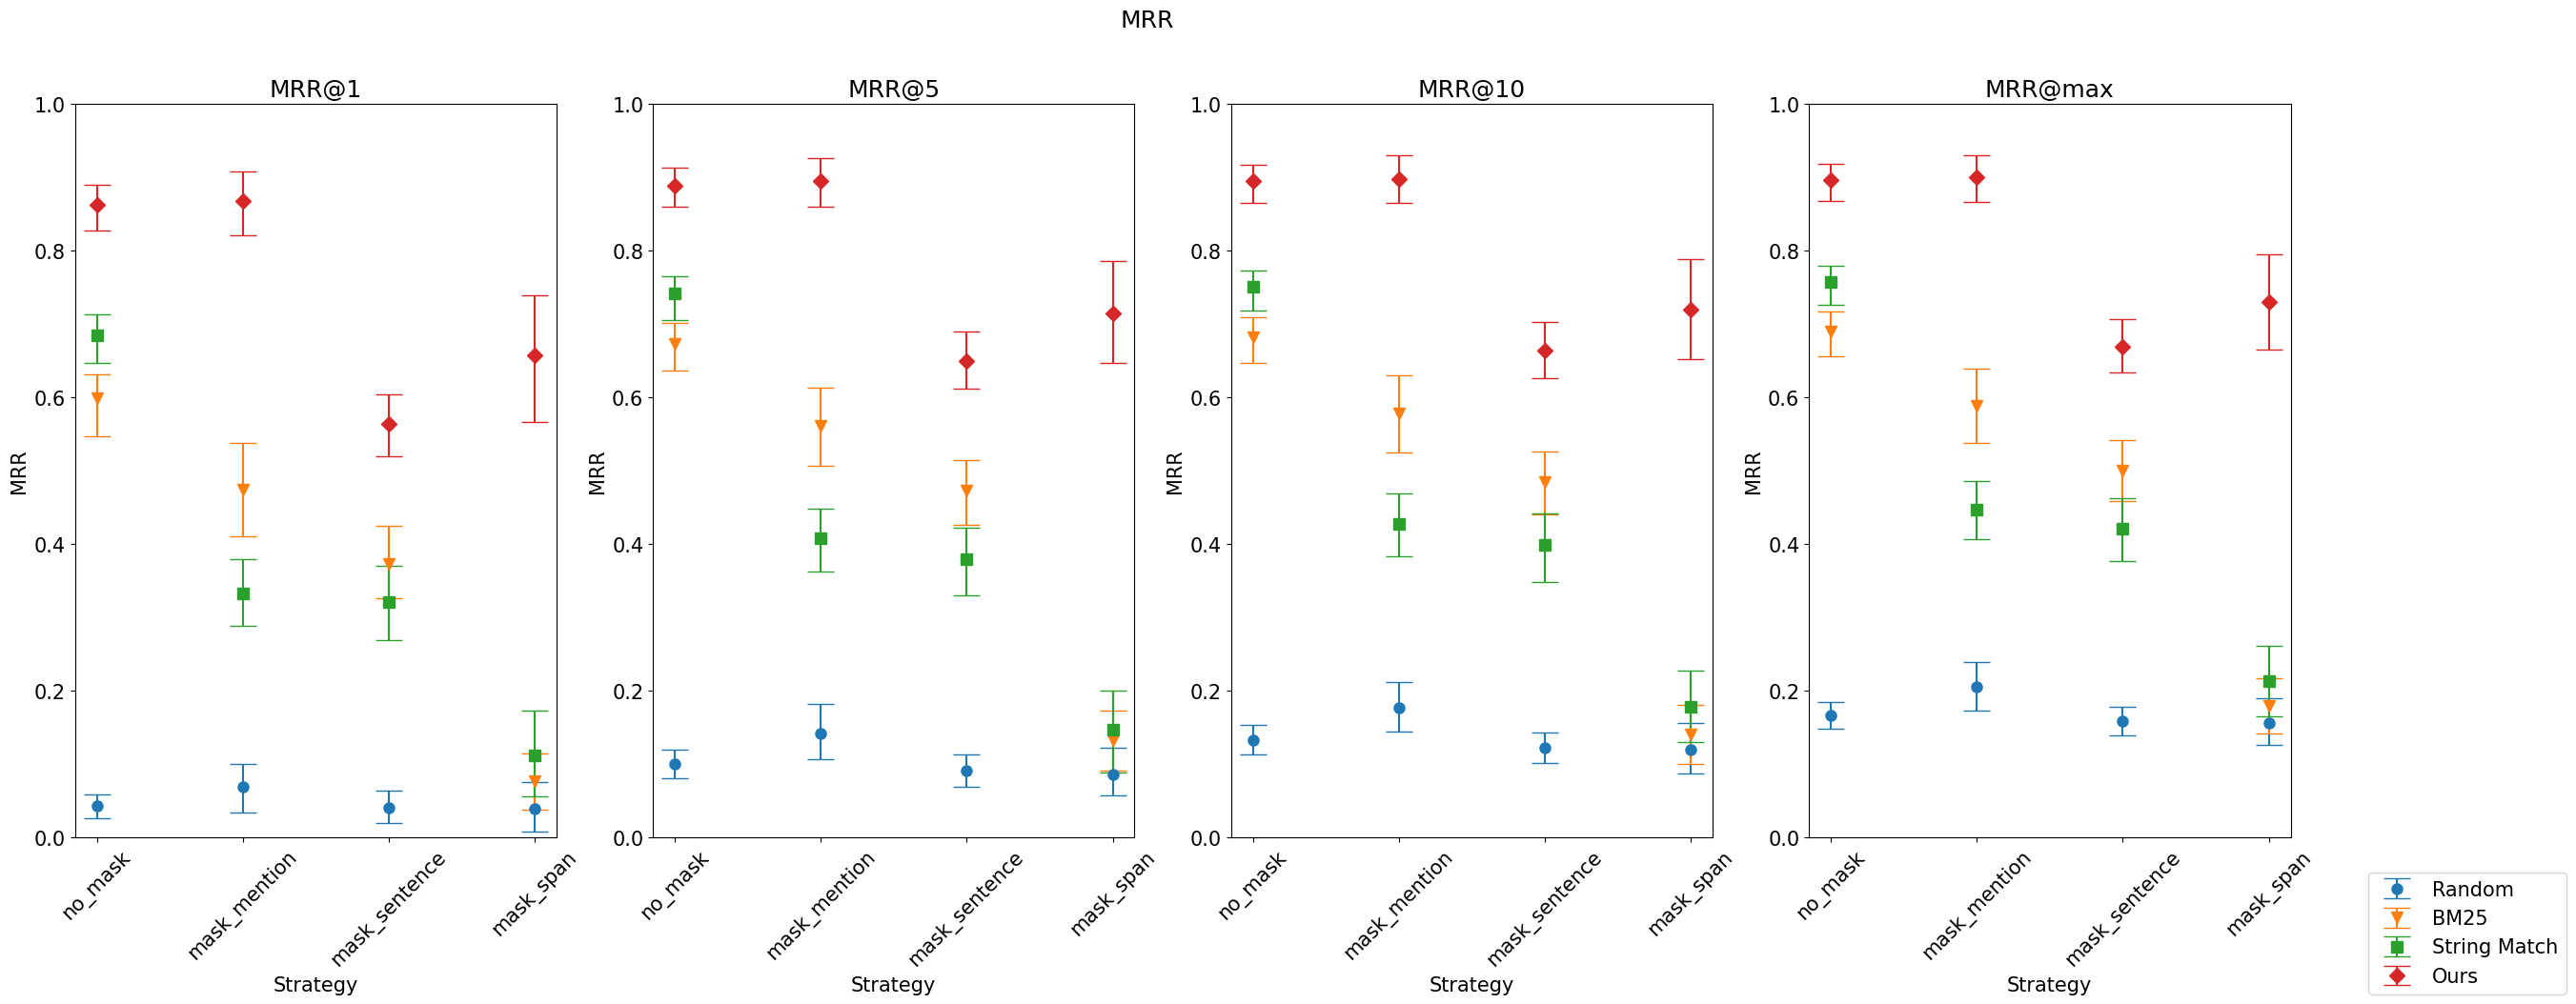

In [205]:
# Plot MRR stratified
# create a grid of 1xC plots, where C is the number of k values
# each plot should have the categories on the x axis and the MRR on the y axis

strategies = ['no_mask', 'mask_mention', 'mask_sentence', 'mask_span']

fig, axs = plt.subplots(1, 4, figsize=(30, 10))
fig.suptitle('MRR')    
for ax in axs:
    ax.set_ylim(0, 1)
    ax.set_xlabel('Strategy')
    ax.set_ylabel('MRR')
    ax.set_title(f"MRR@{list(mrr_at_k[columns[0]].keys())[axs.tolist().index(ax)]}")
    
for column, label, marker in zip(columns, labels, markers):
    for i, k in enumerate(mrr_at_k[column].keys()):
        axs[i].errorbar(strategies, [stratified_mrr_at_k[column][s][k]['score'] for s in strategies], yerr=[[stratified_mrr_at_k[column][s][k]['score'] - stratified_mrr_at_k[column][s][k]['cl'][0] for s in strategies], [stratified_mrr_at_k[column][s][k]['cl'][1] - stratified_mrr_at_k[column][s][k]['score'] for s in strategies]], label=label, marker=marker, capsize=10, markersize=8, linestyle='None')

handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')
# rotate x ticks
for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation=45)

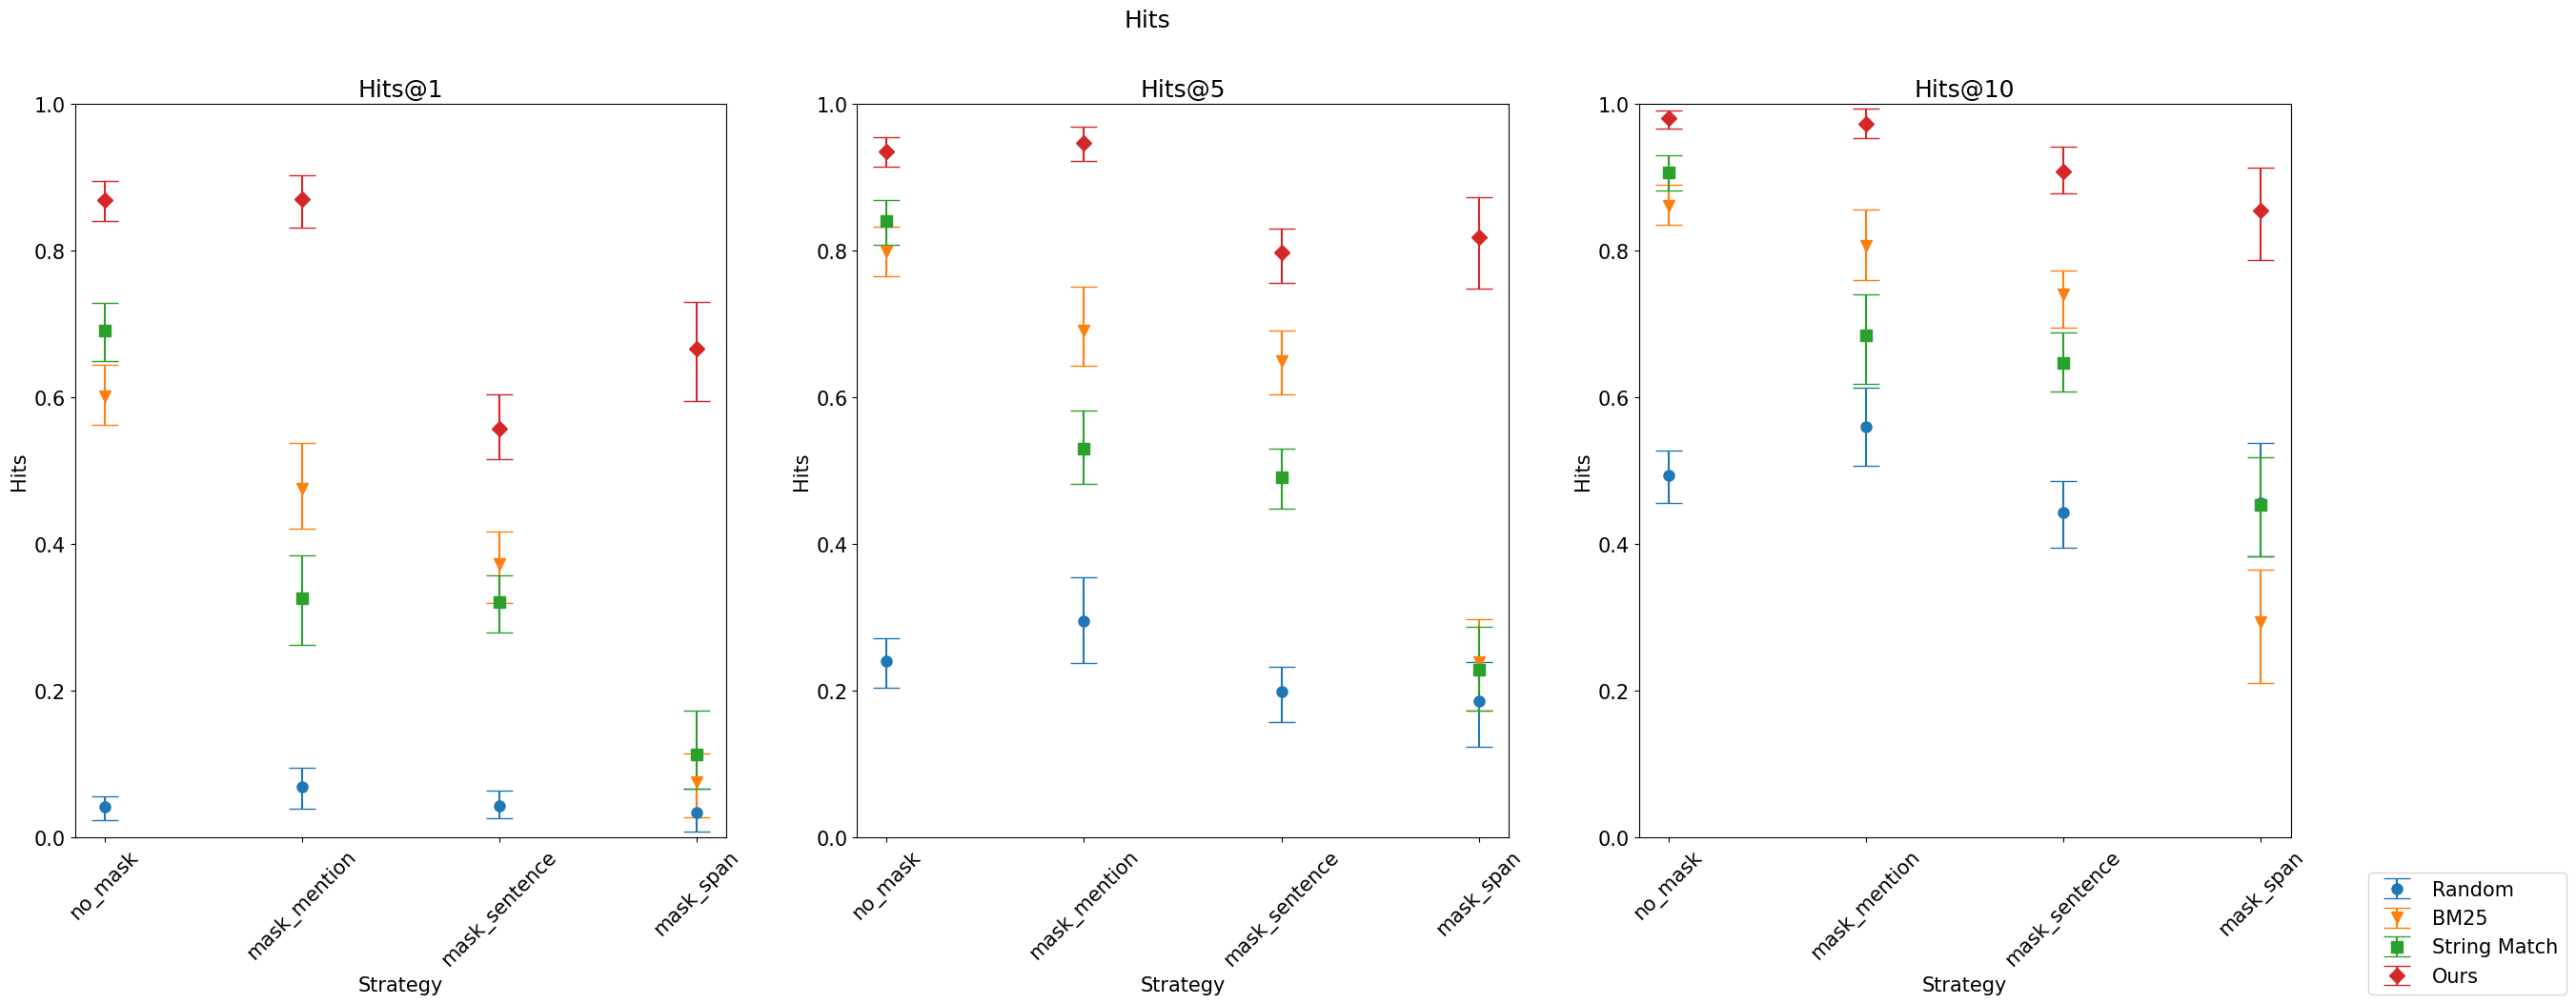

In [206]:
# Plot Hits stratified
# create a grid of 1xC plots, where C is the number of k values
# each plot should have the categories on the x axis and the hits on the y axis

strategies = ['no_mask', 'mask_mention', 'mask_sentence', 'mask_span']

fig, axs = plt.subplots(1, 3, figsize=(30, 10))
fig.suptitle('Hits')
for ax in axs:
    ax.set_ylim(0, 1)
    ax.set_xlabel('Strategy')
    ax.set_ylabel('Hits')
    ax.set_title(f"Hits@{list(hits_at_k[columns[0]].keys())[axs.tolist().index(ax)]}")
    
for column, label, marker in zip(columns, labels, markers):
    for i, k in enumerate(hits_at_k[column].keys()):
        axs[i].errorbar(strategies, [stratified_hits_at_k[column][s][k]['score'] for s in strategies], yerr=[[stratified_hits_at_k[column][s][k]['score'] - stratified_hits_at_k[column][s][k]['cl'][0] for s in strategies], [stratified_hits_at_k[column][s][k]['cl'][1] - stratified_hits_at_k[column][s][k]['score'] for s in strategies]], label=label, marker=marker, capsize=10, markersize=8, linestyle='None')

handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

# rotate x ticks
for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation=45)

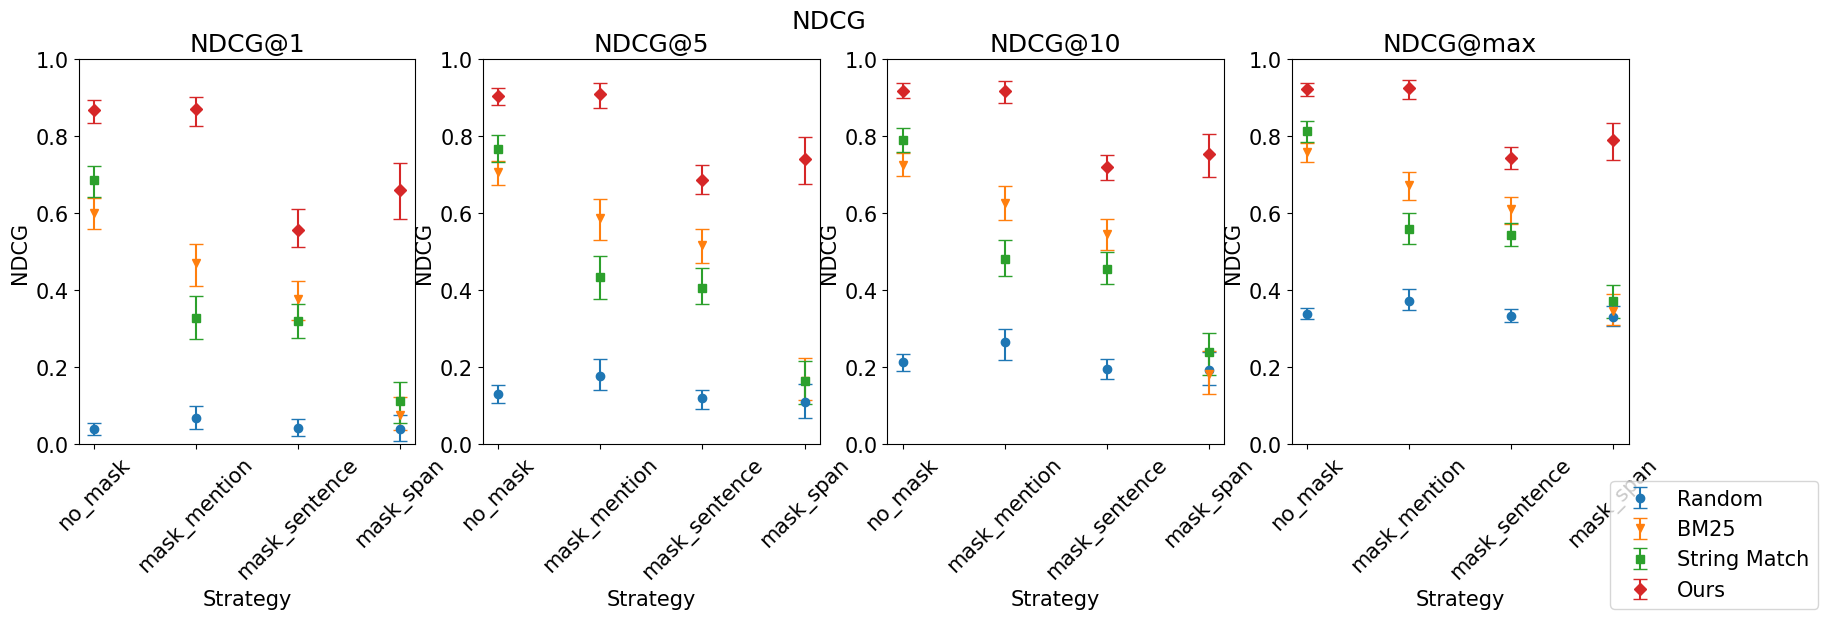

In [207]:
# Plot NDCG stratified
# create a grid of 1xC plots, where C is the number of k values
# each plot should have the categories on the x axis and the ndcg on the y axis

strategies = ['no_mask', 'mask_mention', 'mask_sentence', 'mask_span']

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('NDCG')

for ax in axs:
    ax.set_ylim(0, 1)
    ax.set_xlabel('Strategy')
    ax.set_ylabel('NDCG')
    ax.set_title(f"NDCG@{list(ndcg_at_k[columns[0]].keys())[axs.tolist().index(ax)]}")
    
for column, label, marker in zip(columns, labels, markers):
    for i, k in enumerate(ndcg_at_k[column].keys()):
        axs[i].errorbar(strategies, [stratified_ndcg_at_k[column][s][k]['score'] for s in strategies], yerr=[[stratified_ndcg_at_k[column][s][k]['score'] - stratified_ndcg_at_k[column][s][k]['cl'][0] for s in strategies], [stratified_ndcg_at_k[column][s][k]['cl'][1] - stratified_ndcg_at_k[column][s][k]['score'] for s in strategies]], label=label, marker=marker, capsize=5, linestyle='None')

handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')    

# rotate x ticks
for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation=45)

# Additional plots

## Compare the full model with the model with random section names

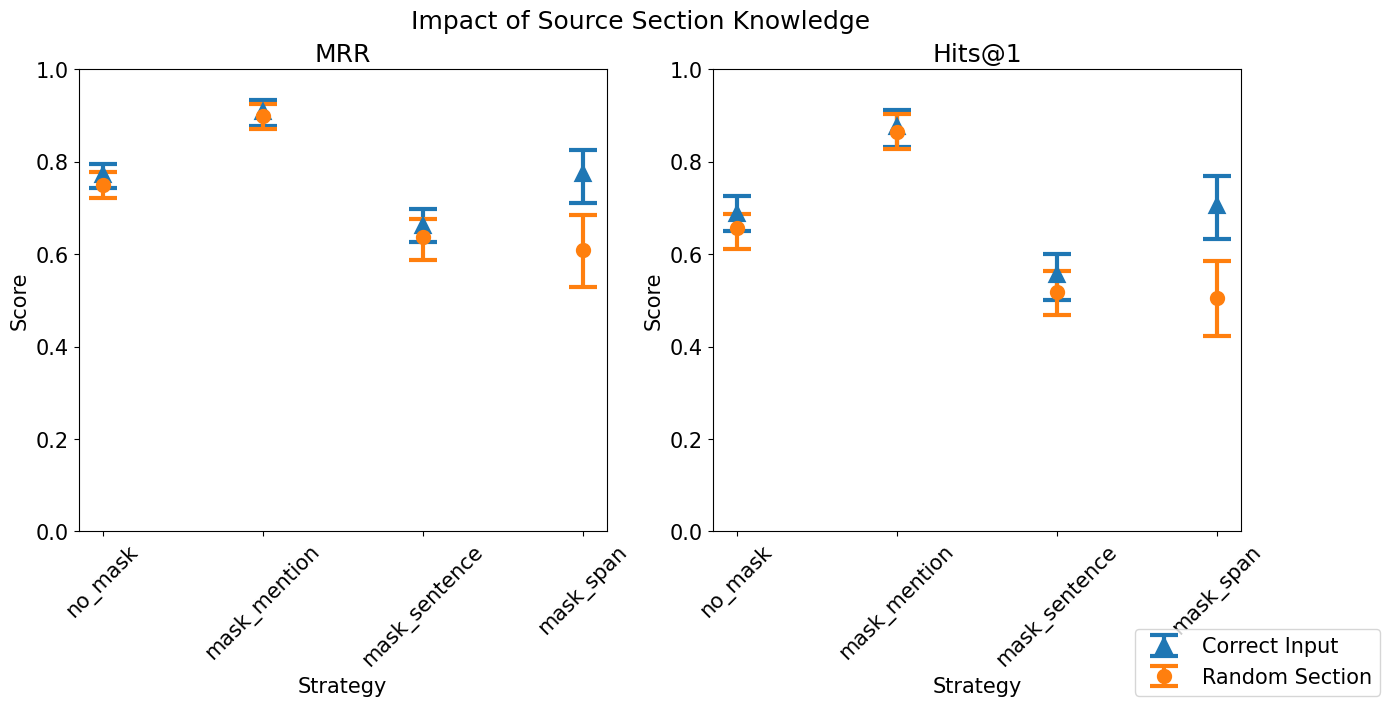

In [208]:
columns = ['model_ranking_corrupt_section_rank', 'model_ranking_corrupt_section_random_rank']
labels = ['Correct Input', 'Random Section']
markers = ['^', 'o']
strategies = ['no_mask', 'mask_mention', 'mask_sentence', 'mask_span']

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Impact of Source Section Knowledge')
for i, ax in enumerate(axs):
    ax.set_ylim(0, 1)
    ax.set_xlabel('Strategy')
    ax.set_ylabel('Score')
    ax.set_title("MRR" if i == 0 else "Hits@1")

for column, label, marker in zip(columns, labels, markers):
    # plot MRR@max in the first plot
    # plot Hits@1 in the second plot
    axs[0].errorbar(strategies, [stratified_mrr_at_k[column][s]['max']['score'] for s in strategies], yerr=[[stratified_mrr_at_k[column][s]['max']['score'] - stratified_mrr_at_k[column][s]['max']['cl'][0] for s in strategies], [stratified_mrr_at_k[column][s]['max']['cl'][1] - stratified_mrr_at_k[column][s]['max']['score'] for s in strategies]], label=label, marker=marker, capsize=10, markersize=8, linestyle='None', elinewidth=3, markeredgewidth=3)
    axs[1].errorbar(strategies, [stratified_hits_at_k[column][s]['1']['score'] for s in strategies], yerr=[[stratified_hits_at_k[column][s]['1']['score'] - stratified_hits_at_k[column][s]['1']['cl'][0] for s in strategies], [stratified_hits_at_k[column][s]['1']['cl'][1] - stratified_hits_at_k[column][s]['1']['score'] for s in strategies]], label=label, marker=marker, capsize=10, markersize=8, linestyle='None', elinewidth=3, markeredgewidth=3)

handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

# rotate x ticks
for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation=45)

## Compare Vanilla BM25 with Mention-Aware BM25

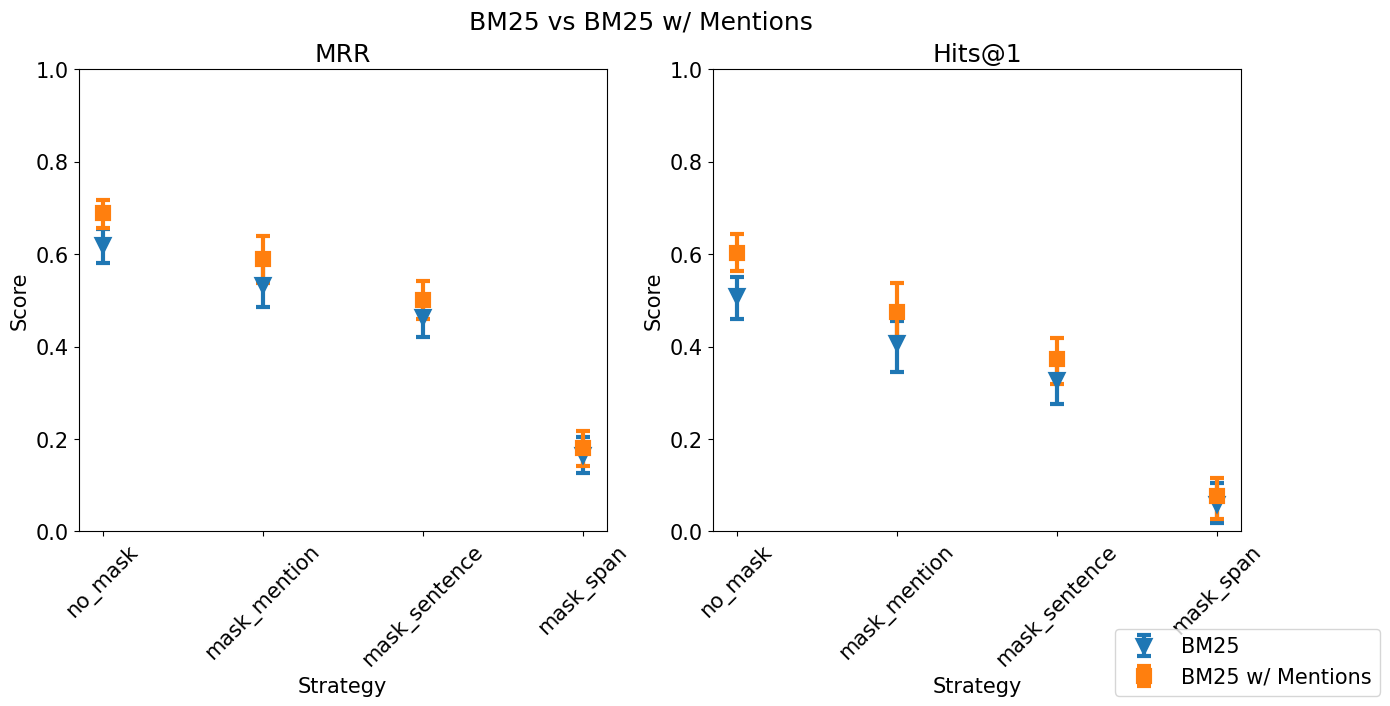

In [209]:
strategies = ['no_mask', 'mask_mention', 'mask_sentence', 'mask_span']
columns = ['bm25_rank', 'bm25_mentions_rank']
labels = ['BM25', 'BM25 w/ Mentions']
markers = ['v', 's']

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('BM25 vs BM25 w/ Mentions')
for i, ax in enumerate(axs):
    ax.set_ylim(0, 1)
    ax.set_xlabel('Strategy')
    ax.set_ylabel('Score')
    ax.set_title("MRR" if i == 0 else "Hits@1")

for column, label, marker in zip(columns, labels, markers):
    axs[0].errorbar(strategies, [stratified_mrr_at_k[column][s]['max']['score'] for s in strategies], yerr=[[stratified_mrr_at_k[column][s]['max']['score'] - stratified_mrr_at_k[column][s]['max']['cl'][0] for s in strategies], [stratified_mrr_at_k[column][s]['max']['cl'][1] - stratified_mrr_at_k[column][s]['max']['score'] for s in strategies]], label=label, marker=marker, capsize=5, linestyle='None', markersize=8, elinewidth=3, markeredgewidth=3)
    axs[1].errorbar(strategies, [stratified_hits_at_k[column][s]['1']['score'] for s in strategies], yerr=[[stratified_hits_at_k[column][s]['1']['score'] - stratified_hits_at_k[column][s]['1']['cl'][0] for s in strategies], [stratified_hits_at_k[column][s]['1']['cl'][1] - stratified_hits_at_k[column][s]['1']['score'] for s in strategies]], label=label, marker=marker, capsize=5, linestyle='None', markersize=8, elinewidth=3, markeredgewidth=3)

handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

# rotate x ticks
for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation=45)

# Compare all the model variations with Ranking loss

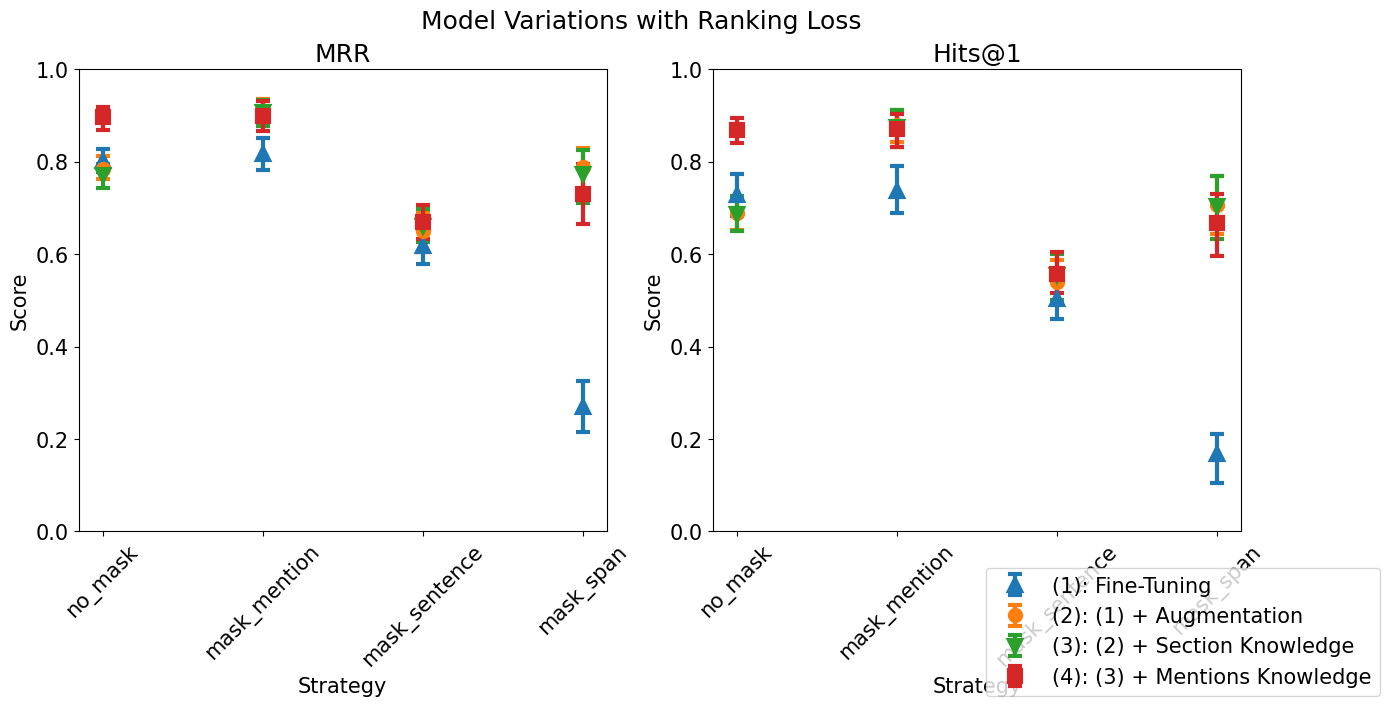

In [210]:
strategies = ['no_mask', 'mask_mention', 'mask_sentence', 'mask_span']
columns = ['model_ranking_rank', 'model_ranking_corrupt_rank', 'model_ranking_corrupt_section_rank', 'model_ranking_corrupt_section_mentions_rank']
labels = ['(1): Fine-Tuning', '(2): (1) + Augmentation', '(3): (2) + Section Knowledge', '(4): (3) + Mentions Knowledge']
markers = ['^', 'o', 'v', 's']

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Model Variations with Ranking Loss')
for i, ax in enumerate(axs):
    ax.set_ylim(0, 1)
    ax.set_xlabel('Strategy')
    ax.set_ylabel('Score')
    ax.set_title("MRR" if i == 0 else "Hits@1")

for column, label, marker in zip(columns, labels, markers):
    axs[0].errorbar(strategies, [stratified_mrr_at_k[column][s]['max']['score'] for s in strategies], yerr=[[stratified_mrr_at_k[column][s]['max']['score'] - stratified_mrr_at_k[column][s]['max']['cl'][0] for s in strategies], [stratified_mrr_at_k[column][s]['max']['cl'][1] - stratified_mrr_at_k[column][s]['max']['score'] for s in strategies]], label=label, marker=marker, capsize=5, linestyle='None', markersize=8, elinewidth=3, markeredgewidth=3)
    axs[1].errorbar(strategies, [stratified_hits_at_k[column][s]['1']['score'] for s in strategies], yerr=[[stratified_hits_at_k[column][s]['1']['score'] - stratified_hits_at_k[column][s]['1']['cl'][0] for s in strategies], [stratified_hits_at_k[column][s]['1']['cl'][1] - stratified_hits_at_k[column][s]['1']['score'] for s in strategies]], label=label, marker=marker, capsize=5, linestyle='None', markersize=8, elinewidth=3, markeredgewidth=3)

handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

# rotate x ticks
for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation=45)

# Compare Ranking Loss with Independent Loss

## Simple Fine-Tuned Model

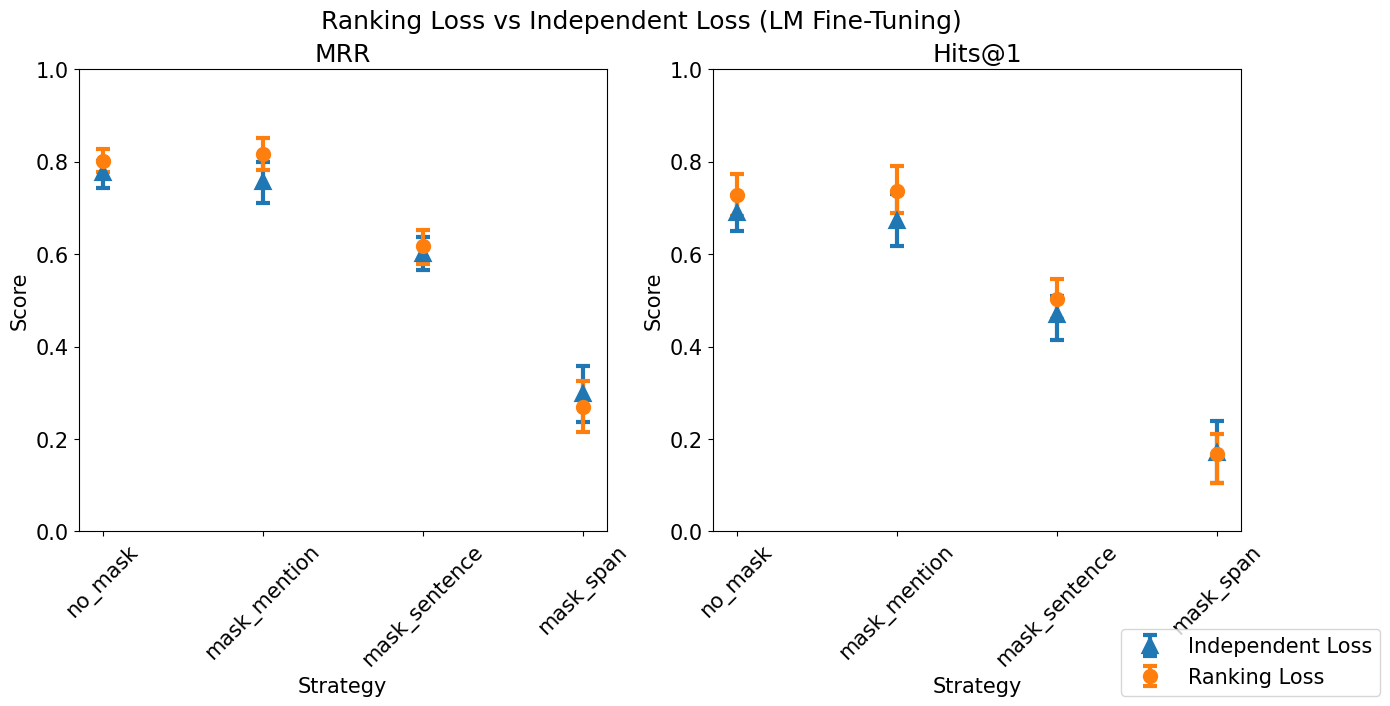

In [211]:
strategies = ['no_mask', 'mask_mention', 'mask_sentence', 'mask_span']
columns = ['model_indep_rank', 'model_ranking_rank']
labels = ['Independent Loss', 'Ranking Loss',]
markers = ['^', 'o']

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Ranking Loss vs Independent Loss (LM Fine-Tuning)')
for i, ax in enumerate(axs):
    ax.set_ylim(0, 1)
    ax.set_xlabel('Strategy')
    ax.set_ylabel('Score')
    ax.set_title("MRR" if i == 0 else "Hits@1")

for column, label, marker in zip(columns, labels, markers):
    axs[0].errorbar(strategies, [stratified_mrr_at_k[column][s]['max']['score'] for s in strategies], yerr=[[stratified_mrr_at_k[column][s]['max']['score'] - stratified_mrr_at_k[column][s]['max']['cl'][0] for s in strategies], [stratified_mrr_at_k[column][s]['max']['cl'][1] - stratified_mrr_at_k[column][s]['max']['score'] for s in strategies]], label=label, marker=marker, capsize=5, linestyle='None', markersize=8, elinewidth=3, markeredgewidth=3)
    axs[1].errorbar(strategies, [stratified_hits_at_k[column][s]['1']['score'] for s in strategies], yerr=[[stratified_hits_at_k[column][s]['1']['score'] - stratified_hits_at_k[column][s]['1']['cl'][0] for s in strategies], [stratified_hits_at_k[column][s]['1']['cl'][1] - stratified_hits_at_k[column][s]['1']['score'] for s in strategies]], label=label, marker=marker, capsize=5, linestyle='None', markersize=8, elinewidth=3, markeredgewidth=3)

handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

# rotate x ticks
for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation=45)

# Model Fine-Tuned with Augmentations, Section Knowledge, Mention Knowledge

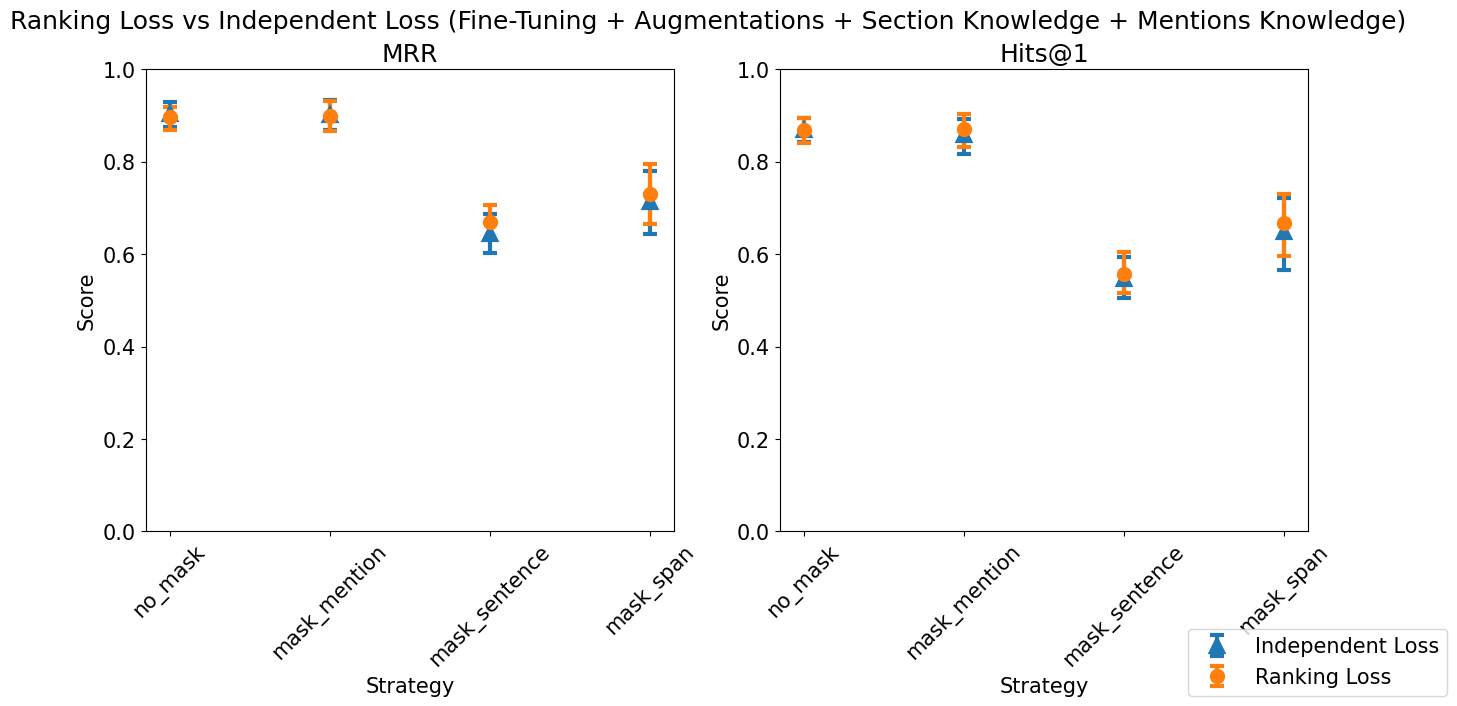

In [212]:
strategies = ['no_mask', 'mask_mention', 'mask_sentence', 'mask_span']
columns = ['model_indep_corrupt_section_mentions_rank', 'model_ranking_corrupt_section_mentions_rank']
labels = ['Independent Loss', 'Ranking Loss',]
markers = ['^', 'o']

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Ranking Loss vs Independent Loss (Fine-Tuning + Augmentations + Section Knowledge + Mentions Knowledge)')
for i, ax in enumerate(axs):
    ax.set_ylim(0, 1)
    ax.set_xlabel('Strategy')
    ax.set_ylabel('Score')
    ax.set_title("MRR" if i == 0 else "Hits@1")

for column, label, marker in zip(columns, labels, markers):
    axs[0].errorbar(strategies, [stratified_mrr_at_k[column][s]['max']['score'] for s in strategies], yerr=[[stratified_mrr_at_k[column][s]['max']['score'] - stratified_mrr_at_k[column][s]['max']['cl'][0] for s in strategies], [stratified_mrr_at_k[column][s]['max']['cl'][1] - stratified_mrr_at_k[column][s]['max']['score'] for s in strategies]], label=label, marker=marker, capsize=5, linestyle='None', markersize=8, elinewidth=3, markeredgewidth=3)
    axs[1].errorbar(strategies, [stratified_hits_at_k[column][s]['1']['score'] for s in strategies], yerr=[[stratified_hits_at_k[column][s]['1']['score'] - stratified_hits_at_k[column][s]['1']['cl'][0] for s in strategies], [stratified_hits_at_k[column][s]['1']['cl'][1] - stratified_hits_at_k[column][s]['1']['score'] for s in strategies]], label=label, marker=marker, capsize=5, linestyle='None', markersize=8, elinewidth=3, markeredgewidth=3)

handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

# rotate x ticks
for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation=45)

# Presentation Plots

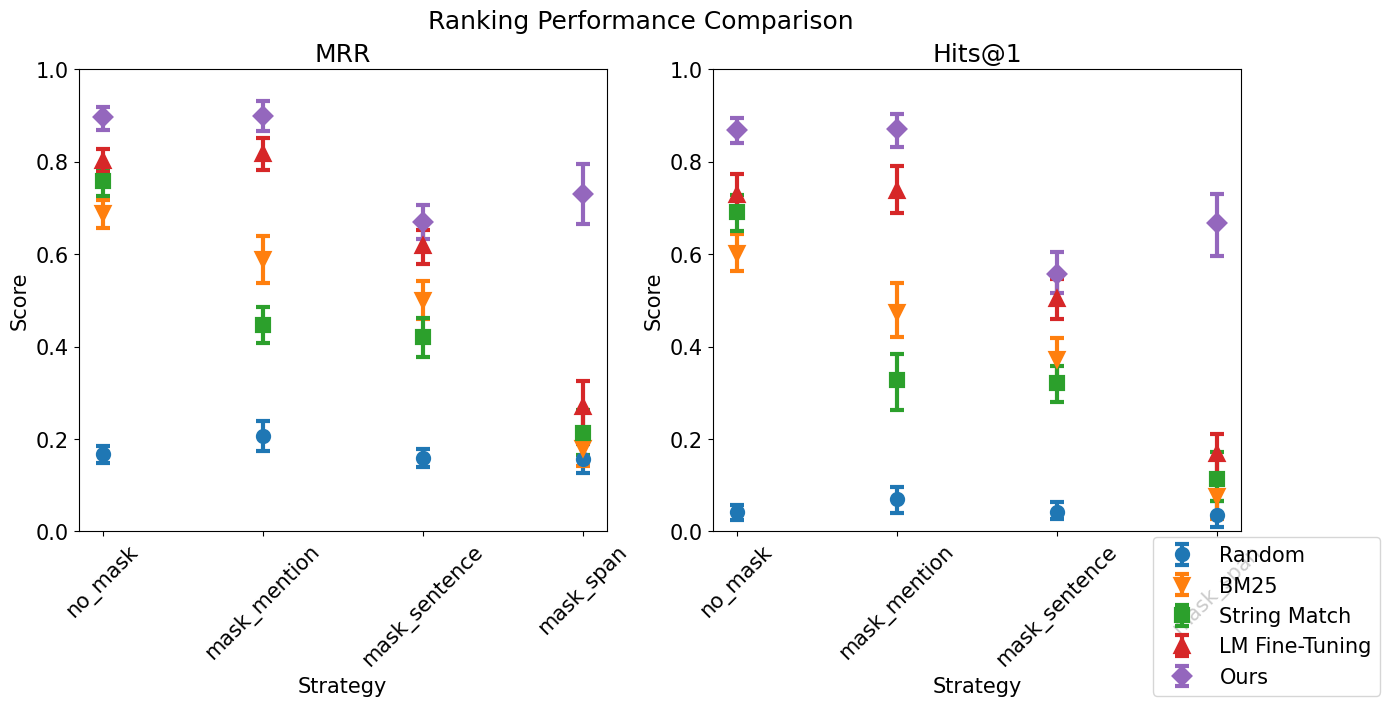

In [213]:
strategies = ['no_mask', 'mask_mention', 'mask_sentence', 'mask_span']
columns = ['random_rank', 'bm25_mentions_rank', 'fuzzy_match_rank', 'model_ranking_rank', 'model_ranking_corrupt_section_mentions_rank']
labels = ['Random', 'BM25', 'String Match', 'LM Fine-Tuning', 'Ours']
markers = ['o', 'v', 's', '^', 'D']

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Ranking Performance Comparison')
for i, ax in enumerate(axs):
    ax.set_ylim(0, 1)
    ax.set_xlabel('Strategy')
    ax.set_ylabel('Score')
    ax.set_title("MRR" if i == 0 else "Hits@1")

for column, label, marker in zip(columns, labels, markers):
    axs[0].errorbar(strategies, [stratified_mrr_at_k[column][s]['max']['score'] for s in strategies], yerr=[[stratified_mrr_at_k[column][s]['max']['score'] - stratified_mrr_at_k[column][s]['max']['cl'][0] for s in strategies], [stratified_mrr_at_k[column][s]['max']['cl'][1] - stratified_mrr_at_k[column][s]['max']['score'] for s in strategies]], label=label, marker=marker, capsize=5, linestyle='None', markersize=8, elinewidth=3, markeredgewidth=3)
    axs[1].errorbar(strategies, [stratified_hits_at_k[column][s]['1']['score'] for s in strategies], yerr=[[stratified_hits_at_k[column][s]['1']['score'] - stratified_hits_at_k[column][s]['1']['cl'][0] for s in strategies], [stratified_hits_at_k[column][s]['1']['cl'][1] - stratified_hits_at_k[column][s]['1']['score'] for s in strategies]], label=label, marker=marker, capsize=5, linestyle='None', markersize=8, elinewidth=3, markeredgewidth=3)

handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

# rotate x ticks
for ax in axs:
    plt.sca(ax)
    plt.xticks(rotation=45)